In [15]:
from pymystem3 import Mystem
from nltk.corpus import stopwords
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
import numpy as np

In [2]:
russian_stopwords = stopwords.words("russian")
m = Mystem()

In [7]:
special = ['beg', 'haps', 'sads', 'excl', 'point', 'myst', 'en', 'не']

def word_map_punct(word):
    happy_smiles = [':)', ';)', ':-)', ':D', ':P', ';-)', '(:', '(-:', '((']
    sad_smiles = [':(', ';(', ':-(', 'D:', ';-(', '):', ')-:', '))']
    for smile in happy_smiles:
        if smile in word:
            return 'haps'
    for smile in sad_smiles:
        if smile in word:
            return 'sads'
    if '!' in word:
        return 'excl'
    if '...' in word:
        return 'myst'
    if '.' in word:
        return 'point'
    return word

def map_punct(line):
    return list(map(word_map_punct, line))

text_corpus = []
lemmatized_text_corpus = []
scores = []
cnt = 0
with open('texts_train.txt', 'r') as texts:
    with open('scores_train.txt', 'r') as scores_file:
        for line, score in zip(texts, scores_file):
            line = line.rstrip('\n')
            score = int(score)
            scores.append(score)
            
            text_corpus.append((line, score))
            lemmatized_text_corpus.append((['beg'] + map_punct(m.lemmatize(line)) + ['en'], score))
            cnt += 1
print(cnt)

20000


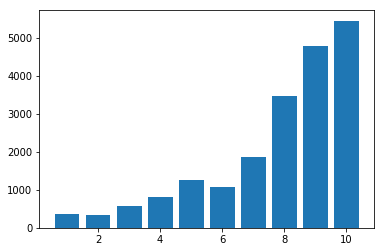

In [22]:
import matplotlib.pyplot as plt

score_stats = {i: 0 for i in range(1, 11)}
for score in scores:
    score_stats[score] += 1

plt.bar(score_stats.keys(), score_stats.values())
plt.show()

In [9]:
samples = {}
for line, score in text_corpus[:5000]:
    samples[score] = line
    
for i in range(1, 11):
    print("Score {}. Text: {}".format(i, samples[i]))

Score 1. Text: В литературном отношении - ниже плинтуса, но почитать имеет смысл, чтобы понять, как устроены мелкие пакостники.
Score 2. Text: Абсолютно согласна с nassy. Автор, ты кто? С чего ты взял, что можешь считать свои банальности истиной? желание возвыситься путем принижения остальных?? так это иллюзия высоты, не более того. Ощущение такое, что книгу "истина в тезисах" написал другой Мороз, а не тот, кто написал "Пособие для гениев". Короче, дрянь книга. А вот "Пособие для гениев" - рекомендую
Score 3. Text: Хрень полная! Похоже на переложенный на бумагу квест. Ходят, ищут, каакие-то подсказки неимоверные. Короче, поддерживаю amam - УЖОС!
Score 4. Text: Довольно бесхребетно и постыло. Однако, некоторые мометы попросту гениальны. Например, сцена с коммивояжером из самого начала.
Score 5. Text: Всё бы, может, и ничего, но эти слёзы-надрывы, надрывы-слёзы... На грани психического срыва, чесслово. И как-то слишком растянуто. Моя психика страдала :)
Score 6. Text: Смотрите, сейчас я

In [10]:
def filter_words(words):
    return list(filter(lambda x: x in special or x[0] in 'абвгдеёжзийклмнопрстуфхцчшщ' \
                       and x not in russian_stopwords, words))

In [11]:
corpus = []
for line, _ in lemmatized_text_corpus:
    line = filter_words(line)
    res = []
    for prev, word in zip([None] + line, line):
        if word == 'не':
            continue
        if prev == 'не':
            res.append("NOT_" + word)
        else:
            res.append(word)
    corpus.append(' '.join(res))
split_point = 19800
    
train, train_scores = corpus[:split_point], scores[:split_point]
test, test_scores = corpus[split_point:], scores[split_point:]

In [12]:
vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1, 2))
X = vectorizer.fit_transform(train)

In [23]:
features = vectorizer.get_feature_names()

In [16]:
regr = RandomForestRegressor(max_depth=10, n_estimators=1000)
regr.fit(X, train_scores)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [17]:
clf = Lasso(max_iter=10000, alpha=0.0001)
clf.fit(X, train_scores)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [24]:
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(min(X.shape[1], 20)):
    print("%d. feature %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature excl (0.119989)
2. feature not_понравиться (0.092019)
3. feature бред (0.079995)
4. feature очень (0.050982)
5. feature скучно (0.048806)
6. feature отличный (0.042369)
7. feature point point (0.033131)
8. feature плохой (0.029898)
9. feature beg (0.028733)
10. feature en (0.022153)
11. feature потратить (0.022120)
12. feature чушь (0.018162)
13. feature любимый (0.016153)
14. feature хороший (0.014967)
15. feature ужас excl (0.011848)
16. feature плохо (0.010578)
17. feature полный (0.010226)
18. feature тупой (0.010217)
19. feature скучный (0.009872)
20. feature отвратительный (0.009591)


In [19]:
test_X = vectorizer.transform(test)
regr.score(test_X, test_scores)

0.11129376875123176

In [20]:
regr.score(X, train_scores)

0.23049910709332078

In [21]:
with open('dataset.txt', 'r') as file:
    with open('answer.txt', 'w') as out:
        qs = []
        for line in file:
            line = filter_words(['beg'] + map_punct(m.lemmatize(line)) + ['en'])
            res = []
            for prev, word in zip([None] + line, line):
                if word == 'не':
                    continue
                if prev == 'не':
                    res.append("NOT_" + word)
                else:
                    res.append(word)
            qs.append(' '.join(res))
        q_X = vectorizer.transform(qs)
        ys = clf.predict(q_X)
        
        for y in ys:
            result = round(y / 10 * 12 - 1)
            result = max(min(10, int(result)), 1)
            out.write("{}\n".format(result))